# Importing relevant things

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
from torch import nn, optim
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Subset, TensorDataset
import os
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
import torch.nn.functional as F
from sklearn import metrics
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
from pytorch_msssim import SSIM
from dataset import *
from device_data_loader import *
from loss import *
from model import *
from params import *
from plot import *
from rcc_trainer import *
from ucc_trainer import *
from autoencoder_trainer import *



# Loading the dataset

In [3]:
splitted_dataset = np.load("../Dataset/splitted_cifar10_dataset.npz")

x_train = splitted_dataset['x_train']
print(f"x_train shape :{x_train.shape}")

y_train = splitted_dataset['y_train']
print(f"y_train shape :{y_train.shape}")

x_val = splitted_dataset['x_val']
print(f"x_val shape :{x_val.shape}")

y_val = splitted_dataset['y_val']
print(f"y_val shape :{y_val.shape}")

x_test = splitted_dataset['x_test']
print(f"x_test shape :{x_test.shape}")

y_test = splitted_dataset['y_test']
print(f"y_test shape: {y_test.shape}")


x_train shape :(40000, 32, 32, 3)
y_train shape :(40000, 1)
x_val shape :(10000, 32, 32, 3)
y_val shape :(10000, 1)
x_test shape :(10000, 32, 32, 3)
y_test shape: (10000, 1)


## Creating the dataset object

In [4]:
dataset = Dataset(x_train, y_train, x_val, y_val, x_test, y_test, debug=True, apply_augmentation=False)

Converted numpy to torch tensors


C:\Parashara\Projects\NUS projects\Sem1\Assignments\NUS-CS5242-Neural-Networks-and-Deep-Learning\Assignment 3 (CIFAR Clustering)\My test code\dataset.py:182: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_class = [torch.tensor(item).permute(2, 0, 1) for item in x[indices]]
C:\Parashara\Projects\NUS projects\Sem1\Assignments\NUS-CS5242-Neural-Networks-and-Deep-Learning\Assignment 3 (CIFAR Clustering)\My test code\dataset.py:183: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_class = [torch.tensor(item) for item in y[indices]]


Creating debug KDE dataloaders


10it [00:00, ?it/s]


Finished constructing the kde_datasets from the test dataset, now creating dataloaders
Created debug KDE dataloaders, now creating debug autoencoder dataloaders
Created autoencoder dataloaders, now creating ucc dataloaders


100%|██████████| 6/6 [00:00<?, ?it/s]


Created ucc dataloaders, now creating rcc dataloaders


100%|██████████| 6/6 [00:00<?, ?it/s]

Initilized all dataloaders


# Checking how one bag looks like

Checking out train


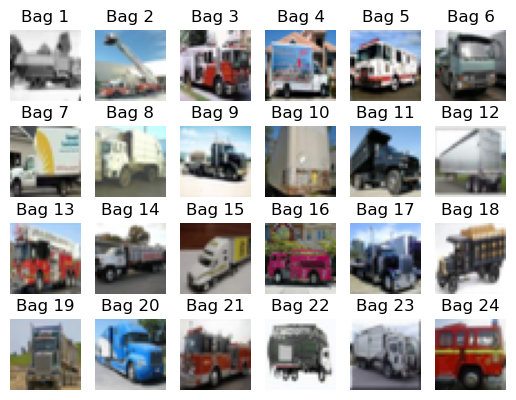

Checking out test


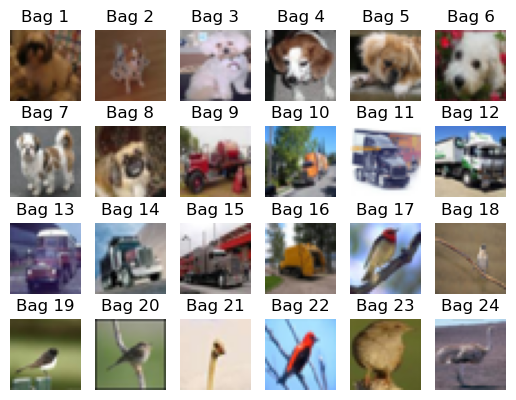

Checking out val


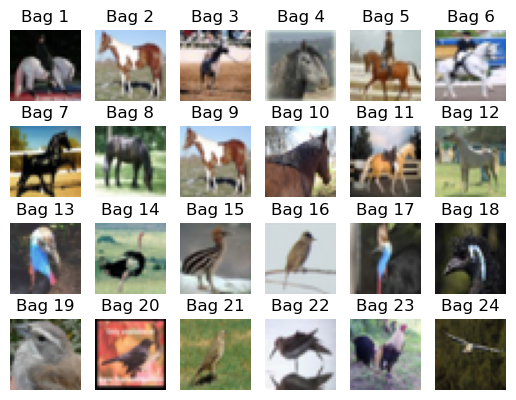

In [5]:
#printing the images in a bag 
import matplotlib.pyplot as plt

tensor_to_img_transform = transforms.ToPILImage()
dataloaders = [dataset.ucc_train_dataloader, dataset.ucc_test_dataloader, dataset.ucc_val_dataloader]
names = ["train", "test", "val"]
# params = {
#     "train":[dataset.train_mu, dataset.train_std],
#     "test": [dataset.test_mu, dataset.test_std],
#     "val": [dataset.val_mu, dataset.val_std]
# }

for ucc_dataloader, name in zip(dataloaders, names):
    print(f"Checking out {name}")
    for data in ucc_dataloader:
        batches, _ = data
        for bag in batches:
            for image_index, image in enumerate(bag):
                # image *= 255
                image = tensor_to_img_transform(image)
                plt.subplot(4, 6, image_index + 1)  # Assuming 24 images per bag
                plt.imshow(image)  # Display the image
                plt.title(f"Bag {image_index + 1}")  # Set the title
                plt.axis('off')  # Turn off axis labels
            plt.show()
            break
        break
plt.show()



## Define the class names

In [6]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


# EXPERIMENT-0: Autoencoder model

In [7]:
experiment0 = "autoencoder"
save_dir = os.path.abspath(config.weights_path)
# autoencoder_model = NewAutoencoder().to(config.device)
autoencoder_model = Autoencoder().to(config.device)

#creating the trainer
autoencoder_trainer = AutoencoderTrainer(experiment0, autoencoder_model, dataset, save_dir)

Autoencoder model initialized!


Going to start training the autoencoder..


Total Epochs: 0.0% |          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/1667 [00:00<?, ?it/s]

Now showing a sample reconstruction
Got a sample reconstruction, now trying to reshape in order to show an example


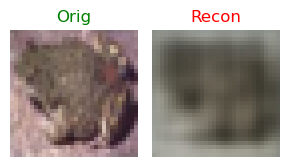

# Epoch 1
[TRAIN]: Epoch AE Loss: 0.020356842320039197
[VAL]: Val AE Loss: 0.017869743496356977
Going to save model autoencoder @ Epoch:1
Saved the model checkpoint for experiment autoencoder for epoch 1
------------------------------------------------------------


Epoch 2/20:   0%|          | 0/1667 [00:00<?, ?it/s]

Now showing a sample reconstruction
Got a sample reconstruction, now trying to reshape in order to show an example


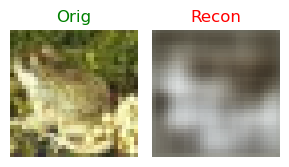

# Epoch 2
[TRAIN]: Epoch AE Loss: 0.020464655393471993
[VAL]: Val AE Loss: 0.018658537772439775
Going to save model autoencoder @ Epoch:2
Saved the model checkpoint for experiment autoencoder for epoch 2
------------------------------------------------------------


Epoch 3/20:   0%|          | 0/1667 [00:00<?, ?it/s]

Now showing a sample reconstruction
Got a sample reconstruction, now trying to reshape in order to show an example


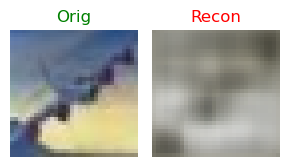

# Epoch 3
[TRAIN]: Epoch AE Loss: 0.023797539043802843
[VAL]: Val AE Loss: 0.021134179706374805
Going to save model autoencoder @ Epoch:3
Saved the model checkpoint for experiment autoencoder for epoch 3
------------------------------------------------------------


Epoch 4/20:   0%|          | 0/1667 [00:00<?, ?it/s]

Now showing a sample reconstruction
Got a sample reconstruction, now trying to reshape in order to show an example


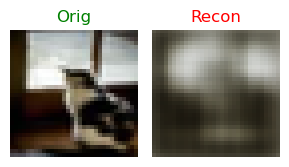

# Epoch 4
[TRAIN]: Epoch AE Loss: 0.027839859230214776
[VAL]: Val AE Loss: 0.022484191782062964
Going to save model autoencoder @ Epoch:4
Saved the model checkpoint for experiment autoencoder for epoch 4
------------------------------------------------------------


Epoch 5/20:   0%|          | 0/1667 [00:00<?, ?it/s]

Now showing a sample reconstruction
Got a sample reconstruction, now trying to reshape in order to show an example


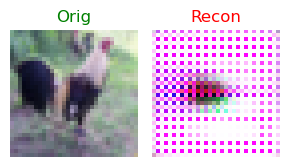

# Epoch 5
[TRAIN]: Epoch AE Loss: 0.04708767796620217
[VAL]: Val AE Loss: 0.19801950774022511
Going to save model autoencoder @ Epoch:5
Saved the model checkpoint for experiment autoencoder for epoch 5
------------------------------------------------------------


Epoch 6/20:   0%|          | 0/1667 [00:00<?, ?it/s]

Now showing a sample reconstruction
Got a sample reconstruction, now trying to reshape in order to show an example


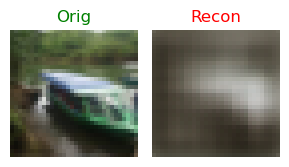

# Epoch 6
[TRAIN]: Epoch AE Loss: 0.09057173564869198
[VAL]: Val AE Loss: 0.023072024319498313
Going to save model autoencoder @ Epoch:6
Saved the model checkpoint for experiment autoencoder for epoch 6
------------------------------------------------------------


Epoch 7/20:   0%|          | 0/1667 [00:00<?, ?it/s]

Now showing a sample reconstruction
Got a sample reconstruction, now trying to reshape in order to show an example


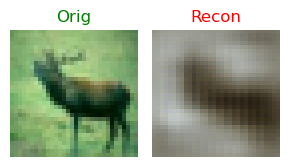

# Epoch 7
[TRAIN]: Epoch AE Loss: 0.08322519822751218
[VAL]: Val AE Loss: 0.02254119719422999
Going to save model autoencoder @ Epoch:7
Saved the model checkpoint for experiment autoencoder for epoch 7
------------------------------------------------------------


Epoch 8/20:   0%|          | 0/1667 [00:00<?, ?it/s]

Now showing a sample reconstruction
Got a sample reconstruction, now trying to reshape in order to show an example


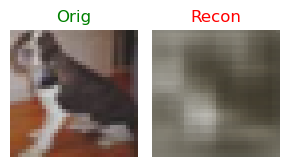

# Epoch 8
[TRAIN]: Epoch AE Loss: 0.06297902237617226
[VAL]: Val AE Loss: 0.027602920530452615
Going to save model autoencoder @ Epoch:8
Saved the model checkpoint for experiment autoencoder for epoch 8
------------------------------------------------------------


Epoch 9/20:   0%|          | 0/1667 [00:00<?, ?it/s]

Now showing a sample reconstruction
Got a sample reconstruction, now trying to reshape in order to show an example


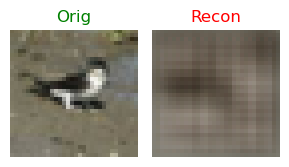

# Epoch 9
[TRAIN]: Epoch AE Loss: 0.07017386707476712
[VAL]: Val AE Loss: 0.021042071948094026
Going to save model autoencoder @ Epoch:9
Saved the model checkpoint for experiment autoencoder for epoch 9
------------------------------------------------------------


Epoch 10/20:   0%|          | 0/1667 [00:00<?, ?it/s]

Now showing a sample reconstruction
Got a sample reconstruction, now trying to reshape in order to show an example


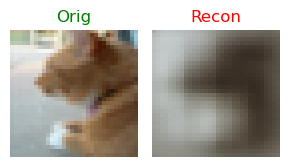

# Epoch 10
[TRAIN]: Epoch AE Loss: 0.0642314122975248
[VAL]: Val AE Loss: 0.025151485488528295
Going to save model autoencoder @ Epoch:10
Saved the model checkpoint for experiment autoencoder for epoch 10
------------------------------------------------------------


Epoch 11/20:   0%|          | 0/1667 [00:00<?, ?it/s]

Now showing a sample reconstruction
Got a sample reconstruction, now trying to reshape in order to show an example


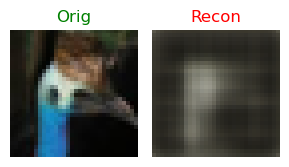

# Epoch 11
[TRAIN]: Epoch AE Loss: 0.05123472478113349
[VAL]: Val AE Loss: 0.02104118430898303
Going to save model autoencoder @ Epoch:11
Saved the model checkpoint for experiment autoencoder for epoch 11
------------------------------------------------------------


Epoch 12/20:   0%|          | 0/1667 [00:00<?, ?it/s]

Now showing a sample reconstruction
Got a sample reconstruction, now trying to reshape in order to show an example


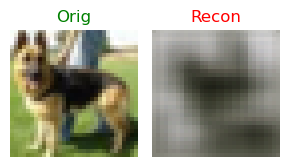

# Epoch 12
[TRAIN]: Epoch AE Loss: 0.028680611290059978
[VAL]: Val AE Loss: 0.01974010347787823
Going to save model autoencoder @ Epoch:12
Saved the model checkpoint for experiment autoencoder for epoch 12
------------------------------------------------------------


Epoch 13/20:   0%|          | 0/1667 [00:00<?, ?it/s]

Now showing a sample reconstruction
Got a sample reconstruction, now trying to reshape in order to show an example


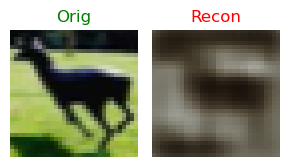

# Epoch 13
[TRAIN]: Epoch AE Loss: 0.02554294842350658
[VAL]: Val AE Loss: 0.02288442131664072
Going to save model autoencoder @ Epoch:13
Saved the model checkpoint for experiment autoencoder for epoch 13
------------------------------------------------------------


Epoch 14/20:   0%|          | 0/1667 [00:00<?, ?it/s]

Now showing a sample reconstruction
Got a sample reconstruction, now trying to reshape in order to show an example


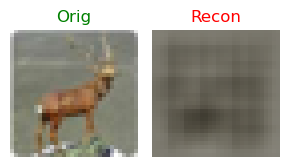

# Epoch 14
[TRAIN]: Epoch AE Loss: 0.023331917344129365
[VAL]: Val AE Loss: 0.022805184303295045
Going to save model autoencoder @ Epoch:14
Saved the model checkpoint for experiment autoencoder for epoch 14
------------------------------------------------------------


Epoch 15/20:   0%|          | 0/1667 [00:00<?, ?it/s]

Now showing a sample reconstruction
Got a sample reconstruction, now trying to reshape in order to show an example


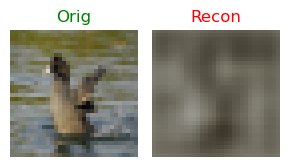

# Epoch 15
[TRAIN]: Epoch AE Loss: 0.021785919476874804
[VAL]: Val AE Loss: 0.017781054246283713
Going to save model autoencoder @ Epoch:15
Saved the model checkpoint for experiment autoencoder for epoch 15
------------------------------------------------------------


Epoch 16/20:   0%|          | 0/1667 [00:00<?, ?it/s]

Now showing a sample reconstruction
Got a sample reconstruction, now trying to reshape in order to show an example


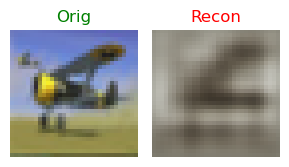

# Epoch 16
[TRAIN]: Epoch AE Loss: 0.020917442866366962
[VAL]: Val AE Loss: 0.0172478538893518
Going to save model autoencoder @ Epoch:16
Saved the model checkpoint for experiment autoencoder for epoch 16
------------------------------------------------------------


Epoch 17/20:   0%|          | 0/1667 [00:00<?, ?it/s]

Now showing a sample reconstruction
Got a sample reconstruction, now trying to reshape in order to show an example


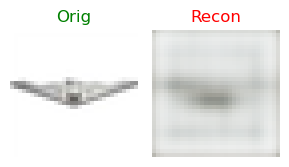

# Epoch 17
[TRAIN]: Epoch AE Loss: 0.01964373948543048
[VAL]: Val AE Loss: 0.018020352348685265
Going to save model autoencoder @ Epoch:17
Saved the model checkpoint for experiment autoencoder for epoch 17
------------------------------------------------------------


Epoch 18/20:   0%|          | 0/1667 [00:00<?, ?it/s]

Now showing a sample reconstruction
Got a sample reconstruction, now trying to reshape in order to show an example


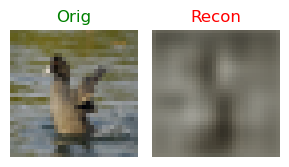

# Epoch 18
[TRAIN]: Epoch AE Loss: 0.018824176894122066
[VAL]: Val AE Loss: 0.015486931406138908
Going to save model autoencoder @ Epoch:18
Saved the model checkpoint for experiment autoencoder for epoch 18
------------------------------------------------------------


Epoch 19/20:   0%|          | 0/1667 [00:00<?, ?it/s]

Now showing a sample reconstruction
Got a sample reconstruction, now trying to reshape in order to show an example


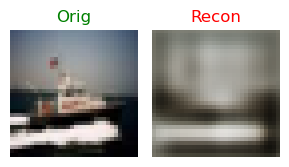

# Epoch 19
[TRAIN]: Epoch AE Loss: 0.01798950169619841
[VAL]: Val AE Loss: 0.015377735541689964
Going to save model autoencoder @ Epoch:19
Saved the model checkpoint for experiment autoencoder for epoch 19
------------------------------------------------------------


Epoch 20/20:   0%|          | 0/1667 [00:00<?, ?it/s]

Now showing a sample reconstruction
Got a sample reconstruction, now trying to reshape in order to show an example


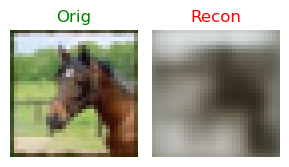

# Epoch 20
[TRAIN]: Epoch AE Loss: 0.017349438863595804
[VAL]: Val AE Loss: 0.015149654909258797
Going to save model autoencoder @ Epoch:20
Saved the model checkpoint for experiment autoencoder for epoch 20
------------------------------------------------------------


In [8]:
print("Going to start training the autoencoder..")
ae_epoch_numbers, training_ae_losses, val_ae_losses = autoencoder_trainer.train(20, epoch_saver_count=1)

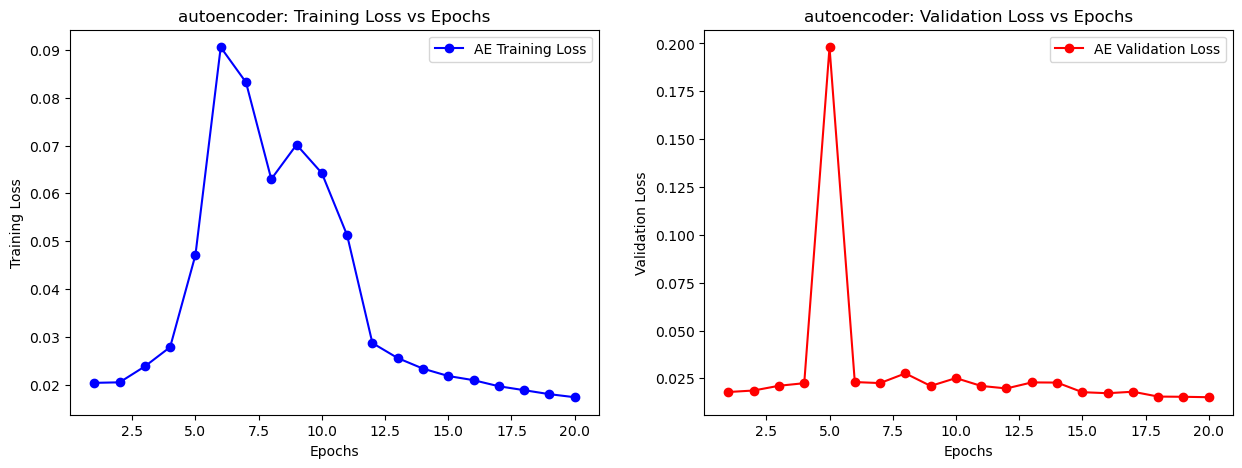

In [9]:
epoch_numbers, training_ae_losses, val_ae_losses = autoencoder_trainer.get_current_running_history_state_hook()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot training losses
axes[0].plot(epoch_numbers, training_ae_losses, marker="o", color="blue", label="AE Training Loss")
axes[0].set_title(f'{experiment0}: Training Loss vs Epochs')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Training Loss')
axes[0].legend()  # Display the legend

# Plot training accuracy
axes[1].plot(epoch_numbers, val_ae_losses, marker="o", color="red", label="AE Validation Loss")
axes[1].set_title(f'{experiment0}: Validation Loss vs Epochs')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Validation Loss')
axes[1].legend()  # Display the legend


In [11]:
min(val_ae_losses)

0.015149654909258797

# EXPERIMENT-1 : UCC Model

This model tries to replicate the paper where we have an autoencoder path and a ucc path.

Similarly experiment-2 will be the improvement model

## Creating the model instances


In [12]:
experiment1 = "ucc"
save_dir = os.path.abspath(config.weights_path)
combined_ucc_model = CombinedUCCModel().to(config.device)

#creating the trainer
ucc_trainer = UCCTrainer(experiment1, combined_ucc_model, dataset, save_dir)

Autoencoder model initialized!
KDE Layer initialized
UCC Predictor model initialized
Combined UCC model initialized


## Training the model

Total Epochs: 0.0% |          | 0/1 [00:00<?, ?it/s]

Epoch 1/1:   0%|          | 0/6 [00:00<?, ?it/s]

Finished computing val stats, now showing a sample reconstruction
Reshaped the original image into bag format
Got a sample reconstruction, now trying to reshape in order to show an example


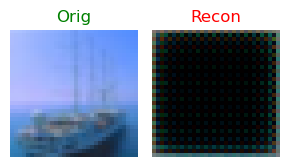

# Epoch 1
[TRAIN]: Epoch Loss: 1.1378988027572632 | AE Loss: 0.017833560705184937 | UCC Loss: 1.6179267764091492 | UCC Acc: 0.16666666666666666
[VAL]: Val Loss: 1.5834956566492717 | Val AE Loss: 0.03587909539540609 | Val UCC Loss: 1.5476165612538655 | Val UCC Acc: 0.3333333333333333
Going to save model ucc @ Epoch:1
Saved the model checkpoint for experiment ucc for epoch 1
------------------------------------------------------------


In [13]:
exp1_epoch_numbers, exp1_training_ae_losses, exp1_training_ucc_losses, exp1_training_losses, exp1_training_ucc_accuracies, exp1_val_ae_losses, exp1_val_ucc_losses, exp1_val_losses, exp1_val_ucc_accuracies = ucc_trainer.train(1, epoch_saver_count=1)

|## Additional Training if required

In [8]:
# exp1_epoch_numbers, exp1_training_ae_losses, exp1_training_ucc_losses, exp1_training_losses, exp1_training_ucc_accuracies, exp1_val_ae_losses, exp1_val_ucc_losses, exp1_val_losses, exp1_val_ucc_accuracies = ucc_trainer.train(10, epoch_saver_count=2, load_from_checkpoint=True, resume_epoch_num=42)

## Plotting the model stats

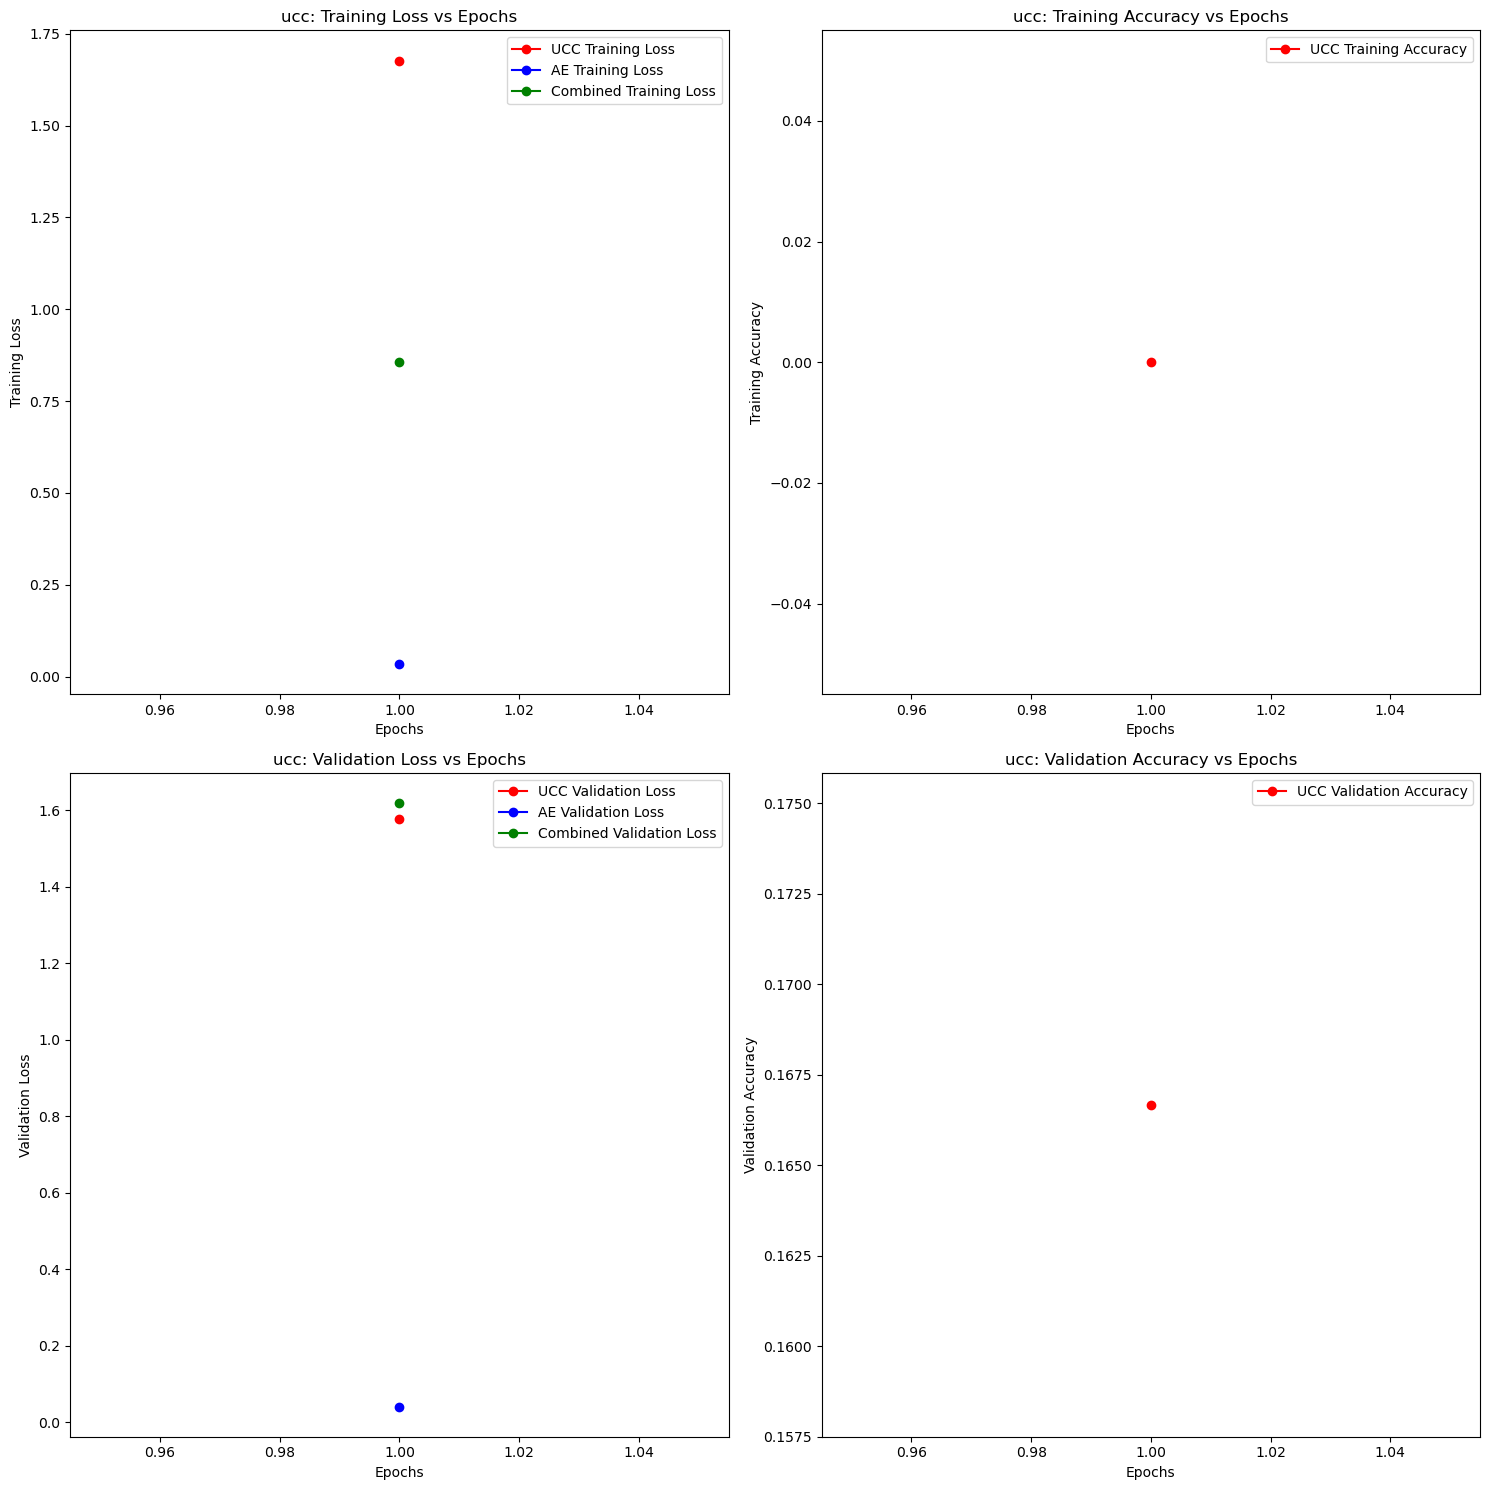

In [9]:
plot_ucc_model_stats(experiment1, exp1_epoch_numbers, exp1_training_ucc_losses, exp1_training_ae_losses, exp1_training_losses,
                     exp1_training_ucc_accuracies, exp1_val_ucc_losses, exp1_val_ae_losses, exp1_val_losses,
                     exp1_val_ucc_accuracies)

## Testing the model

Reshaped the original image into bag format
Got a sample reconstruction, now trying to reshape in order to show an example


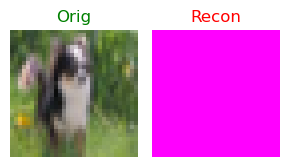

{'avg_test_loss': 1.619402954975764,
 'avg_test_ae_loss': 0.04240123430887858,
 'avg_test_ucc_loss': 1.577001730600993,
 'avg_test_ucc_training_accuracy': 0.16666666666666666}

In [10]:
ucc_trainer.test_model()

## Calculating the Min JS Divergence

In [14]:
exp1_min_js_divg = ucc_trainer.calculate_min_js_divergence()
exp1_min_js_divg

Kde Loader 0 started!


  0%|          | 0/3 [00:00<?, ?it/s]

Kde Loader 0 done!
Kde Loader 1 started!


  0%|          | 0/4 [00:00<?, ?it/s]

Kde Loader 1 done!
Kde Loader 2 started!


  0%|          | 0/4 [00:00<?, ?it/s]

Kde Loader 2 done!
Kde Loader 3 started!


  0%|          | 0/4 [00:00<?, ?it/s]

Kde Loader 3 done!
Kde Loader 4 started!


  0%|          | 0/4 [00:00<?, ?it/s]

Kde Loader 4 done!
Kde Loader 5 started!


  0%|          | 0/4 [00:00<?, ?it/s]

Kde Loader 5 done!
Kde Loader 6 started!


  0%|          | 0/4 [00:00<?, ?it/s]

Kde Loader 6 done!
Kde Loader 7 started!


  0%|          | 0/4 [00:00<?, ?it/s]

Kde Loader 7 done!
Kde Loader 8 started!


  0%|          | 0/3 [00:00<?, ?it/s]

Kde Loader 8 done!
Kde Loader 9 started!


  0%|          | 0/3 [00:00<?, ?it/s]

Kde Loader 9 done!
Computed all the kde's! Now finding min js divergence..
JS Divergence between 0 & 1 is 0.0003984640643466264
JS Divergence between 0 & 2 is 0.0003942651383113116
JS Divergence between 0 & 3 is 0.0004069750721100718
JS Divergence between 0 & 4 is 0.0004080981598235667
JS Divergence between 0 & 5 is 0.0004318654537200928
JS Divergence between 0 & 6 is 0.00039668442332185805
JS Divergence between 0 & 7 is 0.0004069668357260525
JS Divergence between 0 & 8 is 0.00047596066724509
JS Divergence between 0 & 9 is 0.0005022625555284321
JS Divergence between 1 & 2 is 0.0003283998812548816
JS Divergence between 1 & 3 is 0.0003427789779379964
JS Divergence between 1 & 4 is 0.00033496698597446084
JS Divergence between 1 & 5 is 0.00032574840588495135
JS Divergence between 1 & 6 is 0.0003349645994603634
JS Divergence between 1 & 7 is 0.0003190324641764164
JS Divergence between 1 & 8 is 0.00036760111106559634
JS Divergence between 1 & 9 is 0.00038880150532349944
JS Divergence between

tensor(0.0003, device='cuda:0', grad_fn=<MulBackward0>)

## Calculating the Clustering Accuracy

In [15]:
exp1_clustering_accuracies = ucc_trainer.calculate_clustering_accuracy()
exp1_clustering_accuracies

No of autoencoder loaders are 10
Started pure autoencoder loader 0 of length 81


  0%|          | 0/81 [00:00<?, ?it/s]

Started pure autoencoder loader 1 of length 105


  0%|          | 0/105 [00:00<?, ?it/s]

Started pure autoencoder loader 2 of length 105


  0%|          | 0/105 [00:00<?, ?it/s]

Started pure autoencoder loader 3 of length 98


  0%|          | 0/98 [00:00<?, ?it/s]

Started pure autoencoder loader 4 of length 108


  0%|          | 0/108 [00:00<?, ?it/s]

Started pure autoencoder loader 5 of length 119


  0%|          | 0/119 [00:00<?, ?it/s]

Started pure autoencoder loader 6 of length 103


  0%|          | 0/103 [00:00<?, ?it/s]

Started pure autoencoder loader 7 of length 101


  0%|          | 0/101 [00:00<?, ?it/s]

Started pure autoencoder loader 8 of length 88


  0%|          | 0/88 [00:00<?, ?it/s]

Started pure autoencoder loader 9 of length 92


  0%|          | 0/92 [00:00<?, ?it/s]

Got the latent features for all test images, now doing Kmeans


C:\Users\paras\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Got the kmeans predicted labels, now computing clustering accuracy


0.139

In [13]:
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------#

# EXPERIMENT-2 : UCC-RCC Model

This model is an improvement to the original model as we are also trying to predict the RCC (Real Class Counts) as a separate multitask path. This approach in theory should improve the accuracy of the model.

Additionally we use the SSIM loss for the autoencoder as that is known to be a good loss function when it comes to autoencoders.



## Creating the model instances


In [16]:
experiment2 = "ucc-rcc"
save_dir = os.path.abspath(config.weights_path)
combined_rcc_model = CombinedRCCModel(config.device).to(config.device)

#creating the trainer
rcc_trainer = RCCTrainer(experiment2, combined_rcc_model, dataset, save_dir)

Autoencoder model initialized!
KDE Layer initialized
UCC Predictor model initialized
KDE Layer initialized
RCC Predictor module initilized
Combined RCC Predictor initialized


## Training the model

Total Epochs: 0.0% |          | 0/2 [00:00<?, ?it/s]

Epoch 1/2:   0%|          | 0/6 [00:00<?, ?it/s]

Reshaped the original image into bag format
Got a sample reconstruction, now trying to reshape in order to show an example


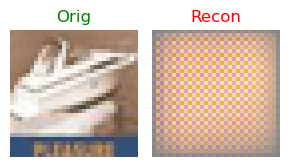

# Epoch 1
[TRAIN]: Epoch Loss: 26.275459448496502 | AE Loss: 0.00812267263730367 | UCC Loss: 1.6255550980567932 | UCC Acc: 0.16666666666666666 | RCC Loss: 64.05903148651123 | RCC Acc: 0.19444444444444445
[VAL]: Val Loss: 33.95991865793864 | Val AE Loss: 0.018796364466349285 | Val UCC Loss: 1.380949894587199 | Val UCC Acc: 0.3333333333333333 | Val RCC Loss: 32.56017208099365 | Val RCC Acc: 0.3055555555555556
Going to save model ucc-rcc @ Epoch:1
Saved the model checkpoint for experiment ucc-rcc for epoch 1
------------------------------------------------------------


Epoch 2/2:   0%|          | 0/6 [00:00<?, ?it/s]

Reshaped the original image into bag format
Got a sample reconstruction, now trying to reshape in order to show an example


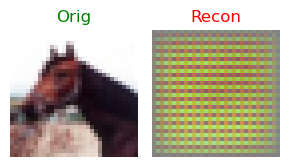

# Epoch 2
[TRAIN]: Epoch Loss: 20.646721680959065 | AE Loss: 0.013215184211730957 | UCC Loss: 1.346304178237915 | UCC Acc: 0.3333333333333333 | RCC Loss: 50.263889948527016 | RCC Acc: 0.2361111111111111
[VAL]: Val Loss: 50.18500232696533 | Val AE Loss: 0.009428054094314575 | Val UCC Loss: 1.380949894587199 | Val UCC Acc: 0.3333333333333333 | Val RCC Loss: 48.79462432861328 | Val RCC Acc: 0.2916666666666667
Going to save model ucc-rcc @ Epoch:2
Saved the model checkpoint for experiment ucc-rcc for epoch 2
------------------------------------------------------------


In [17]:
exp2_epoch_numbers, exp2_training_ae_losses, exp2_training_ucc_losses, exp2_training_rcc_losses, exp2_training_losses, exp2_training_ucc_accuracies, exp2_training_rcc_accuracies, exp2_val_ae_losses, exp2_val_ucc_losses, exp2_val_rcc_losses, exp2_val_losses, exp2_val_ucc_accuracies, exp2_val_rcc_accuracies = rcc_trainer.train(2, epoch_saver_count=1)

## Additional Training if required


In [18]:
 # exp2_epoch_numbers, exp2_training_ae_losses, exp2_training_ucc_losses, exp2_training_rcc_losses, exp2_training_losses, exp2_training_ucc_accuracies, exp2_training_rcc_accuracies, exp2_val_ae_losses, exp2_val_ucc_losses, exp2_val_rcc_losses, exp2_val_losses, exp2_val_ucc_accuracies, exp2_val_rcc_accuracies = rcc_trainer.train(10, epoch_saver_count=2, load_from_checkpoint=True, resume_epoch_num=42)

## Plotting the model stats

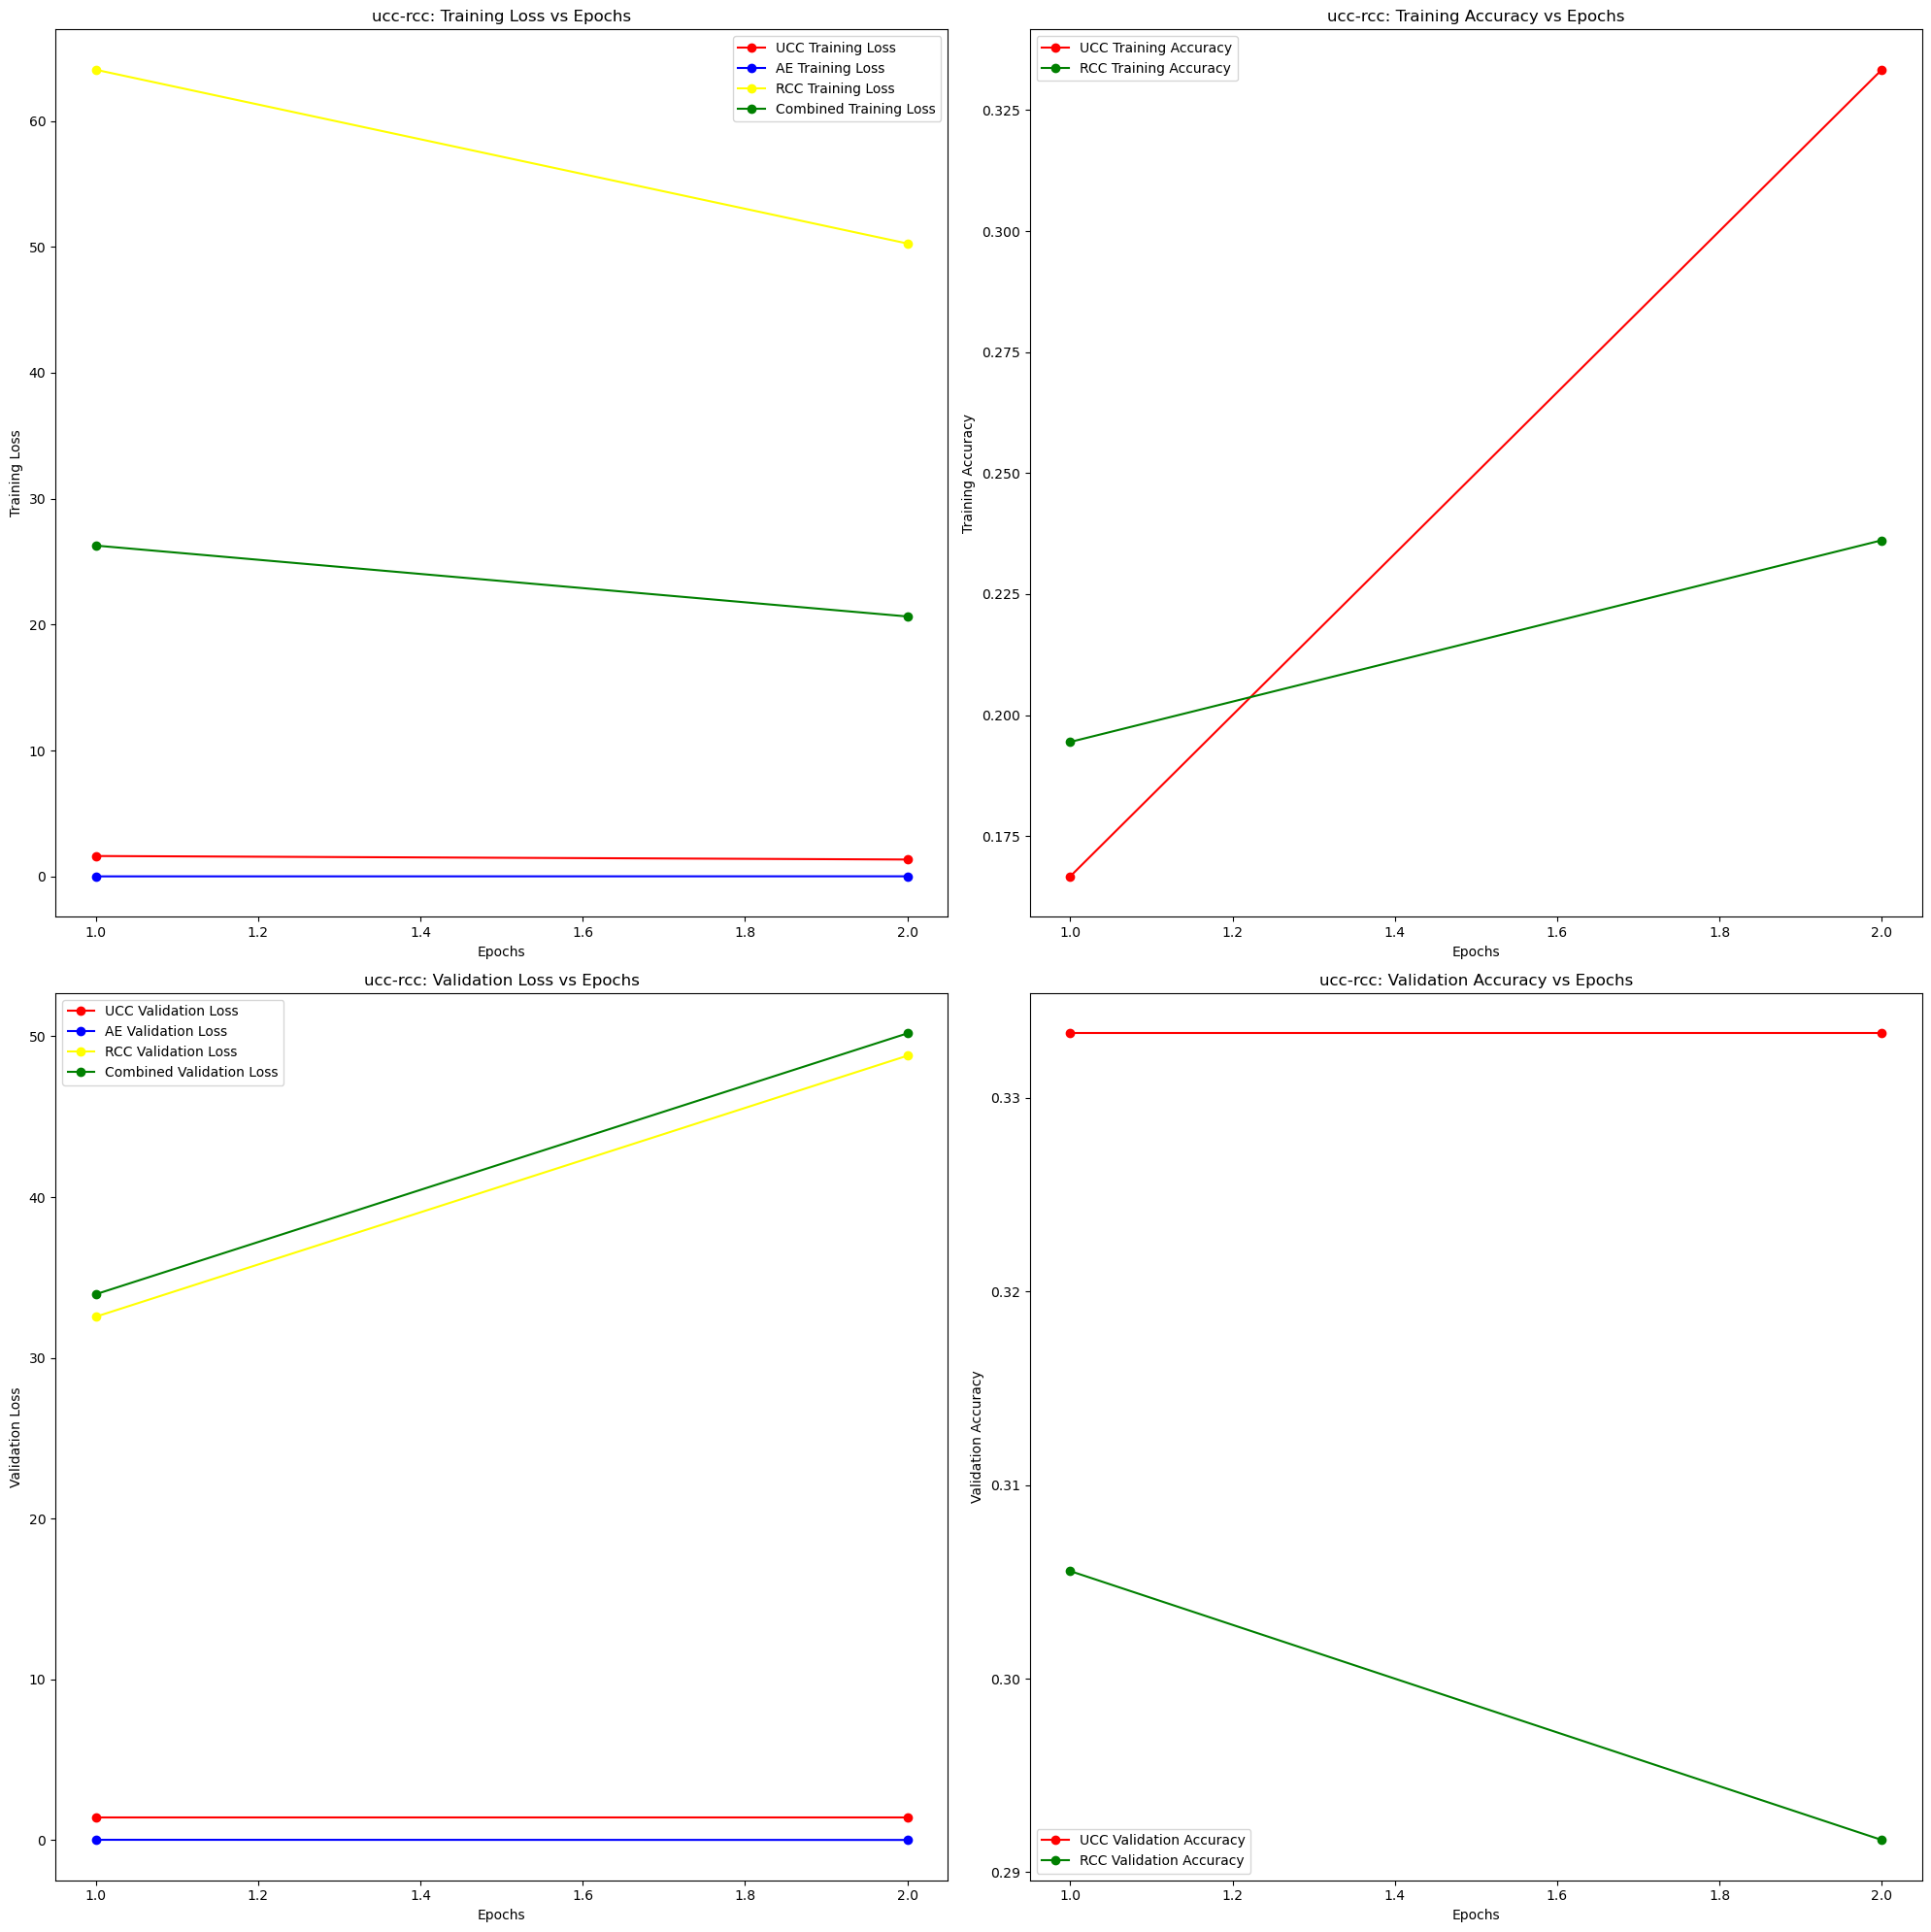

In [19]:
plot_ucc_rcc_model_stats(experiment2, exp2_epoch_numbers, exp2_training_ucc_losses, exp2_training_ae_losses,
                         exp2_training_rcc_losses, exp2_training_losses, exp2_training_ucc_accuracies,
                         exp2_training_rcc_accuracies, exp2_val_ucc_losses, exp2_val_ae_losses, exp2_val_rcc_losses,
                         exp2_val_losses, exp2_val_ucc_accuracies, exp2_val_rcc_accuracies)

## Testing the model

Reshaped the original image into bag format
Got a sample reconstruction, now trying to reshape in order to show an example


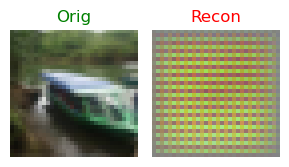

{'avg_test_loss': 53.44649569193522,
 'avg_test_ae_loss': 0.009151607751846313,
 'avg_test_ucc_loss': 1.380949894587199,
 'avg_test_rcc_loss': 52.05639394124349,
 'avg_test_ucc_training_accuracy': 0.3333333333333333,
 'avg_test_rcc_training_accuracy': 0.2847222222222222}

In [20]:
rcc_trainer.test_model()

## Calculating the Min JS Divergence

In [21]:
exp2_min_js_divg = rcc_trainer.calculate_min_js_divergence()
exp2_min_js_divg

Kde Loader 0 started!


  0%|          | 0/3 [00:00<?, ?it/s]

Kde Loader 0 done!
Kde Loader 1 started!


  0%|          | 0/4 [00:00<?, ?it/s]

Kde Loader 1 done!
Kde Loader 2 started!


  0%|          | 0/4 [00:00<?, ?it/s]

Kde Loader 2 done!
Kde Loader 3 started!


  0%|          | 0/4 [00:00<?, ?it/s]

Kde Loader 3 done!
Kde Loader 4 started!


  0%|          | 0/4 [00:00<?, ?it/s]

Kde Loader 4 done!
Kde Loader 5 started!


  0%|          | 0/4 [00:00<?, ?it/s]

Kde Loader 5 done!
Kde Loader 6 started!


  0%|          | 0/4 [00:00<?, ?it/s]

Kde Loader 6 done!
Kde Loader 7 started!


  0%|          | 0/4 [00:00<?, ?it/s]

Kde Loader 7 done!
Kde Loader 8 started!


  0%|          | 0/3 [00:00<?, ?it/s]

Kde Loader 8 done!
Kde Loader 9 started!


  0%|          | 0/3 [00:00<?, ?it/s]

Kde Loader 9 done!
Computed all the kde's! Now finding min js divergence..
JS Divergence between 0 & 1 is 0.0005218551959842443
JS Divergence between 0 & 2 is 0.0031916541047394276
JS Divergence between 0 & 3 is 0.0036968477070331573
JS Divergence between 0 & 4 is 0.004764772020280361
JS Divergence between 0 & 5 is 0.0015441721770912409
JS Divergence between 0 & 6 is 0.010745635256171227
JS Divergence between 0 & 7 is 0.0030193908605724573
JS Divergence between 0 & 8 is 0.0007937938207760453
JS Divergence between 0 & 9 is 0.0005847945576533675
JS Divergence between 1 & 2 is 0.001121950219385326
JS Divergence between 1 & 3 is 0.0013082746881991625
JS Divergence between 1 & 4 is 0.0016116471961140633
JS Divergence between 1 & 5 is 0.0005972374929115176
JS Divergence between 1 & 6 is 0.004524801857769489
JS Divergence between 1 & 7 is 0.0009494026307947934
JS Divergence between 1 & 8 is 0.0013474675361067057
JS Divergence between 1 & 9 is 0.0009531223913654685
JS Divergence between 2 & 3 

tensor(0.0001, device='cuda:0', grad_fn=<MulBackward0>)

## Calculating the Clustering Accuracy

In [22]:
exp2_clustering_accuracies = rcc_trainer.calculate_clustering_accuracy()
exp2_clustering_accuracies

No of autoencoder loaders are 10
Started pure autoencoder loader 0 of length 81


  0%|          | 0/81 [00:00<?, ?it/s]

Started pure autoencoder loader 1 of length 105


  0%|          | 0/105 [00:00<?, ?it/s]

Started pure autoencoder loader 2 of length 105


  0%|          | 0/105 [00:00<?, ?it/s]

Started pure autoencoder loader 3 of length 98


  0%|          | 0/98 [00:00<?, ?it/s]

Started pure autoencoder loader 4 of length 108


  0%|          | 0/108 [00:00<?, ?it/s]

Started pure autoencoder loader 5 of length 119


  0%|          | 0/119 [00:00<?, ?it/s]

Started pure autoencoder loader 6 of length 103


  0%|          | 0/103 [00:00<?, ?it/s]

Started pure autoencoder loader 7 of length 101


  0%|          | 0/101 [00:00<?, ?it/s]

Started pure autoencoder loader 8 of length 88


  0%|          | 0/88 [00:00<?, ?it/s]

Started pure autoencoder loader 9 of length 92


  0%|          | 0/92 [00:00<?, ?it/s]

Got the latent features for all test images, now doing Kmeans


C:\Users\paras\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Got the kmeans predicted labels, now computing clustering accuracy


0.187